In [3]:
# import all necessary stuff
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress
import numpy as np

In [4]:
# import and read in CSV
amazon_data_path = "Resources/Amazon_Data.csv"

amazon_data = pd.read_csv(amazon_data_path, delimiter=',', header=0)

In [6]:
# create starter data frame from CSV
amazon_df = pd.DataFrame(amazon_data)

amazon_df.head()

,Index,Timestamp,age,Gender,Purchase_Frequency,Purchase_Categories,Personalized_Recommendation_Frequency,Browsing_Frequency,Product_Search_Method,Search_Result_Exploration,...,Saveforlater_Frequency,Review_Left,Review_Reliability,Review_Helpfulness,Personalized_Recommendation_Frequency,Recommendation_Helpfulness,Rating_Accuracy,Shopping_Satisfaction,Service_Appreciation,Improvement_Areas
0,1,2023/06/04 1:28:19 PM GMT+5:30,23,Female,Few times a month,Beauty and Personal Care,Yes,Few times a week,Keyword,Multiple pages,...,Sometimes,Yes,Occasionally,Yes,2,Yes,1,1,Competitive prices,Reducing packaging waste
1,2,2023/06/04 1:28:19 PM GMT+5:31,23,Female,Once a month,Clothing and Fashion,Yes,Few times a month,Keyword,Multiple pages,...,Rarely,No,Heavily,Yes,2,Sometimes,3,2,Wide product selection,Reducing packaging waste
2,3,2023/06/04 1:28:19 PM GMT+5:32,24,Prefer not to say,Few times a month,"Groceries and Gourmet Food,Clothing and Fashion",No,Few times a month,Keyword,Multiple pages,...,Rarely,No,Occasionally,No,4,No,3,3,Competitive prices,Product quality and accuracy
3,4,2023/06/04 1:28:19 PM GMT+5:33,24,Female,Once a month,"Beauty and Personal Care,Clothing and Fashion,...",Sometimes,Few times a month,Keyword,First page,...,Sometimes,Yes,Heavily,Yes,3,Sometimes,3,4,Competitive prices,Product quality and accuracy
4,5,2023/06/04 1:28:19 PM GMT+5:34,22,Female,Less than once a month,"Beauty and Personal Care,Clothing and Fashion",Yes,Few times a month,Filter,Multiple pages,...,Rarely,No,Heavily,Yes,4,Yes,2,2,Competitive prices,Product quality and accuracy


In [7]:
# rename columns
amazon_df = amazon_df.rename(columns={"Personalized_Recommendation_Frequency":"Recommendation_Frequency",
                              "Product_Search_Method":"Search_Method",
                              "Search_Result_Exploration":"Exploration",
                              "Saveforlater_Frequency":"Save_for_Later_Frequency",
                              "age":"Age"})
amazon_df.head()

# define variables as dictionaries or lists here
age = amazon_df["Age"]
print(age)

0      23
1      23
2      24
3      24
4      22
       ..
597    23
598    23
599    23
600    23
601    23
Name: Age, Length: 602, dtype: int64


In [8]:
amazon_df.head()

,Index,Timestamp,Age,Gender,Purchase_Frequency,Purchase_Categories,Recommendation_Frequency,Browsing_Frequency,Search_Method,Exploration,...,Save_for_Later_Frequency,Review_Left,Review_Reliability,Review_Helpfulness,Personalized_Recommendation_Frequency,Recommendation_Helpfulness,Rating_Accuracy,Shopping_Satisfaction,Service_Appreciation,Improvement_Areas
0,1,2023/06/04 1:28:19 PM GMT+5:30,23,Female,Few times a month,Beauty and Personal Care,Yes,Few times a week,Keyword,Multiple pages,...,Sometimes,Yes,Occasionally,Yes,2,Yes,1,1,Competitive prices,Reducing packaging waste
1,2,2023/06/04 1:28:19 PM GMT+5:31,23,Female,Once a month,Clothing and Fashion,Yes,Few times a month,Keyword,Multiple pages,...,Rarely,No,Heavily,Yes,2,Sometimes,3,2,Wide product selection,Reducing packaging waste
2,3,2023/06/04 1:28:19 PM GMT+5:32,24,Prefer not to say,Few times a month,"Groceries and Gourmet Food,Clothing and Fashion",No,Few times a month,Keyword,Multiple pages,...,Rarely,No,Occasionally,No,4,No,3,3,Competitive prices,Product quality and accuracy
3,4,2023/06/04 1:28:19 PM GMT+5:33,24,Female,Once a month,"Beauty and Personal Care,Clothing and Fashion,...",Sometimes,Few times a month,Keyword,First page,...,Sometimes,Yes,Heavily,Yes,3,Sometimes,3,4,Competitive prices,Product quality and accuracy
4,5,2023/06/04 1:28:19 PM GMT+5:34,22,Female,Less than once a month,"Beauty and Personal Care,Clothing and Fashion",Yes,Few times a month,Filter,Multiple pages,...,Rarely,No,Heavily,Yes,4,Yes,2,2,Competitive prices,Product quality and accuracy


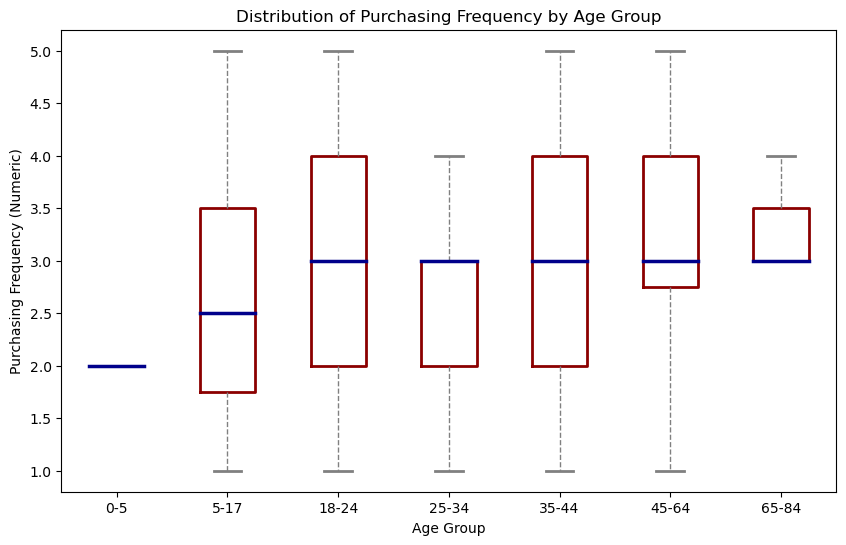

<Figure size 640x480 with 0 Axes>

In [22]:
# Question 1: How do different age group's purchasing behaviors compare on Amazon? 

# Creating bins for the age ranges * These ranges are the standard used the in grouping ages by the US Census
age_bins = [0, 5, 17, 24, 34, 44, 64, 84]
age_group_labels = ['0-5', '5-17', '18-24', '25-34', '35-44', '45-64', '65-84']

# Create a new column in the CSV for "Age_Group" 
amazon_df['Age_Group'] = pd.cut(amazon_df['Age'], bins=age_bins, labels=age_group_labels, right=False)

# Mapping the categorical values to numerical values for Purchasing Frequency
purchasing_mapping_dict = {
    "Less than once a month": 1,
    "Once a month": 2,
    "Few times a month": 3,
    "Once a week": 4,
    "Multiple times a week": 5
}

amazon_df['Purchase_Frequency_Numerical'] = amazon_df['Purchase_Frequency'].map(purchasing_mapping_dict)

# Boxplot
plt.figure(figsize=(10, 6))
boxprops = dict(linestyle='-', linewidth=2, color='darkred')
whiskerprops = dict(linestyle='--', linewidth=1, color='gray')
medianprops = dict(linestyle='-', linewidth=2.5, color='darkblue')
capprops = dict(linestyle='-', linewidth=2, color='gray')

# Use 'Age_Group' for the boxplot
plt.boxplot([amazon_df[amazon_df['Age_Group'] == age_group]['Purchase_Frequency_Numerical'] for age_group in age_group_labels],
            labels=age_group_labels, showfliers=False, boxprops=boxprops, whiskerprops=whiskerprops,
            medianprops=medianprops, capprops=capprops)

plt.title('Distribution of Purchasing Frequency by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Purchasing Frequency (Numeric)')
plt.show()
plt.savefig('Output/Age_Purchasing_Boxplot.png')




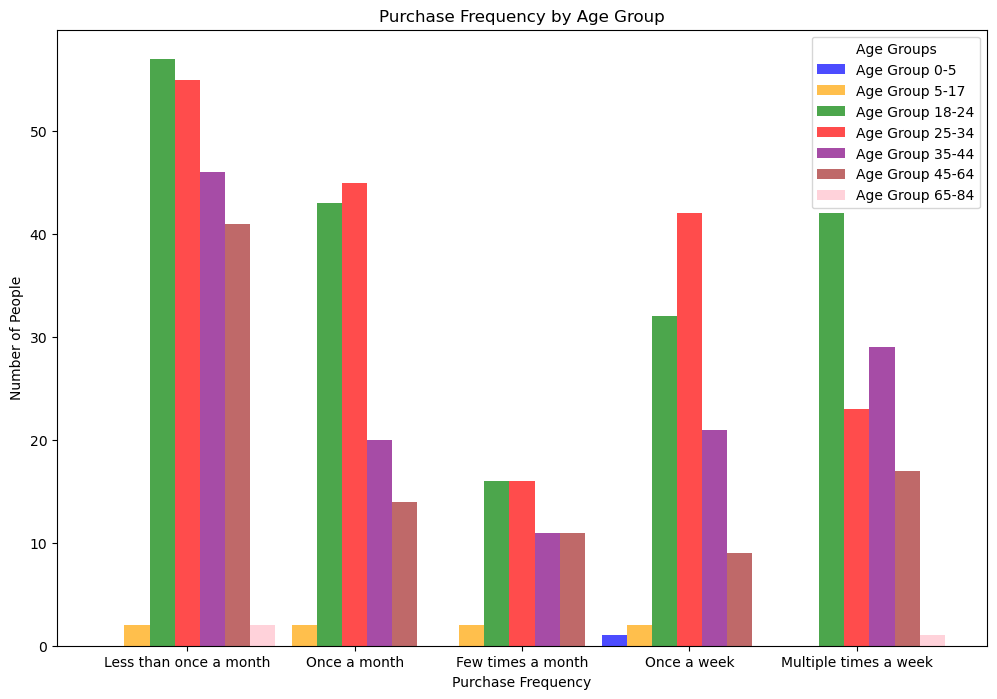

<Figure size 640x480 with 0 Axes>

In [21]:
# Plot the bar chart
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.15  # Adjust this value to change the width of each bar

for i, (age_group, color) in enumerate(zip(age_group_labels, colors)):
    x_positions = np.arange(len(x_labels)) + (i * bar_width)
    plt.bar(x_positions, grouped_data.loc[age_group], label=f'Age Group {age_group}', color=color, width=bar_width, alpha=0.7)

plt.xlabel('Purchase Frequency')
plt.ylabel('Number of People')
plt.title('Purchase Frequency by Age Group')
plt.legend(title='Age Groups')

# Set x-axis tick positions and labels
ax.set_xticks(np.arange(len(x_labels)) + (len(age_group_labels) / 2 - 0.5) * bar_width)
ax.set_xticklabels(x_labels)

plt.show()
plt.savefig('Output/Age_Purchasing_BarChart.png')

In [ ]:
# Question 2: Investigate top factors for cart abandonment – Kyle










In [ ]:
# Question 3: Review question – Eileen. Which type of consumer leaves the most reviews? The least?


#just a test!  







In [ ]:
# Question 4: Is there a strong correlation between browsing frequency and purchase frequency?








